<a href="https://colab.research.google.com/github/syedshubha/PulseSCQ/blob/main/JailBreakQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet qutip qutip-qip matplotlib numpy &> /dev/null

In [2]:
import qutip as qt
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate, gate_sequence_product
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def psi_theta(theta):
    return (np.cos(theta) * qt.basis(2, 0) + np.sin(theta) * qt.basis(2, 1)).unit()

def initial_state(theta):
    psi_in = psi_theta(theta)
    zero = qt.basis(2, 0)
    return qt.tensor(psi_in, zero, zero)

def teleportation_gates():
    qc = QubitCircuit(3)
    qc.add_gate(Gate("SNOT", targets=[1]))
    qc.add_gate(Gate("CNOT", controls=[1], targets=[2]))
    qc.add_gate(Gate("CNOT", controls=[0], targets=[1]))
    qc.add_gate(Gate("SNOT", targets=[0]))
    return qc

def run_teleportation_corrected(theta, measurement_outcome):
    state_init = initial_state(theta)
    qc_gates = teleportation_gates()
    U_gates = gate_sequence_product(qc_gates.propagators())
    state_final_pre_measure = U_gates * state_init
    m0, m1 = measurement_outcome
    proj_state_alice = qt.tensor(qt.basis(2, m0), qt.basis(2, m1))
    P_alice = proj_state_alice * proj_state_alice.dag()
    P_full = qt.tensor(P_alice, qt.qeye(2))
    state_post_measure_unnorm = P_full * state_final_pre_measure
    prob = state_post_measure_unnorm.norm()**2
    if prob < 1e-9: return None
    state_post_measure = state_post_measure_unnorm.unit()
    correction_gates = []
    if m1 == 1: correction_gates.append(Gate("X", targets=[2]))
    if m0 == 1: correction_gates.append(Gate("Z", targets=[2]))
    if correction_gates:
        qc_corr = QubitCircuit(3)
        for gate in correction_gates: qc_corr.add_gate(gate)
        U_corr = gate_sequence_product(qc_corr.propagators())
        state_corrected = U_corr * state_post_measure
    else:
        state_corrected = state_post_measure
    rho_bob = state_corrected.ptrace(2)
    return rho_bob

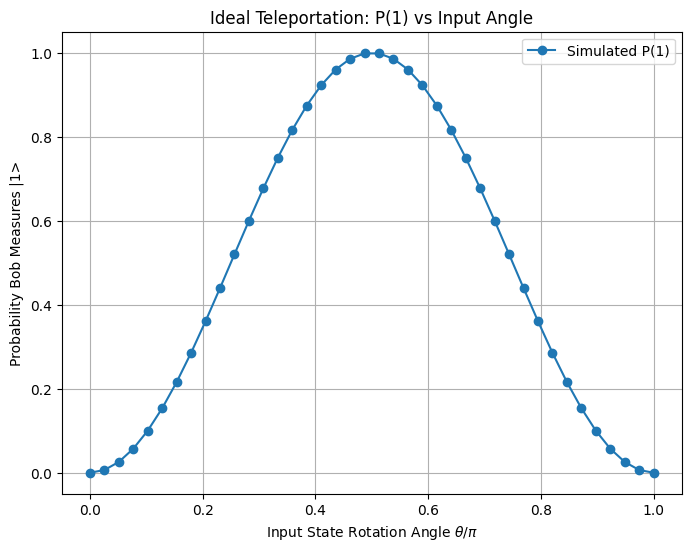

In [4]:
# --- Simulation Loop and Plotting ---

thetas = np.linspace(0, np.pi, 40)
probabilities_1 = []
measurement_outcome_to_simulate = (0, 0)
P1 = qt.basis(2, 1) * qt.basis(2, 1).dag() # Projector |1><1|

for theta in thetas:
    output_rho = run_teleportation_corrected(theta, measurement_outcome=measurement_outcome_to_simulate)
    if output_rho is not None:
        prob_1 = qt.expect(P1, output_rho)
        probabilities_1.append(np.real(prob_1))
    else:
         probabilities_1.append(np.nan)

theoretical_prob_1 = [np.sin(t/2)**2 for t in thetas]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(thetas / np.pi, probabilities_1, 'o-', markersize=6, label="Simulated P(1)")


plt.xlabel(r"Input State Rotation Angle $\theta/\pi$")
plt.ylabel("Probability Bob Measures |1>")
plt.title("Ideal Teleportation: P(1) vs Input Angle")

plt.grid(True)
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()

In [5]:
def apply_eve_attack(state_pre, J, A, coup, delta=0):
    sx = qt.sigmax()
    I  = qt.qeye(2)

    s1, s2 = coup
    # Crosstalk coupling between qubit1 and qubit2
    H_couple = J * qt.tensor(I, s1, s2)

    # Pulse amplitude
    def pulse_coeff(t, args):
        return A*np.cos(delta*t)  # constant drive

    # Drive on qubit 0:  σₓ ⊗ I ⊗ I
    H_p0 = [qt.tensor(sx, I, I), pulse_coeff]
    # Drive on qubit 1:  I ⊗ σₓ ⊗ I
    H_p1 = [qt.tensor(I, sx, I), pulse_coeff]

    H = [H_couple, H_p0, H_p1]

    c_ops = []

    # Evolve for a short "attack window"
    t_attack = np.linspace(0, 1.0, 50)
    sol = qt.mesolve(H, state_pre, t_attack, c_ops, [])

    # Return the last state after Eve's pulse
    return sol.states[-1]


In [6]:
def run_teleportation_corrected_all_outcomes(theta, J, A, coup, delta=0, eve_attack=False):
    # Step 1: prepare initial state and apply teleportation gates
    state_init = initial_state(theta)
    qc_gates = teleportation_gates()
    U_gates = gate_sequence_product(qc_gates.propagators())
    state_pre_measure = U_gates * state_init

    # Step 2: apply Eve's pulse attack if enabled
    if eve_attack:
        state_pre_measure = apply_eve_attack(state_pre_measure, J, A, coup, delta)

    # Step 3: sum over all 4 measurement outcomes with proper correction
    final_state_bob = 0
    total_prob = 0

    for m0 in [0, 1]:
        for m1 in [0, 1]:
            # Projection operator on Alice's qubits
            proj_alice = qt.tensor(
                qt.basis(2, m0) * qt.basis(2, m0).dag(),
                qt.basis(2, m1) * qt.basis(2, m1).dag(),
                qt.qeye(2)
            )
            post_unnorm = proj_alice * state_pre_measure
            prob = post_unnorm.norm()**2

            if prob < 1e-12:
                continue

            state_post = post_unnorm.unit()

            # Apply local correction based on (m0, m1)
            qc_corr = QubitCircuit(3)
            if m1 == 1:
                qc_corr.add_gate(Gate("X", targets=[2]))
            if m0 == 1:
                qc_corr.add_gate(Gate("Z", targets=[2]))

            if qc_corr.gates:
                U_corr = gate_sequence_product(qc_corr.propagators())
                state_post = U_corr * state_post

            # Add weighted contribution
            rho_bob = state_post.ptrace(2)  # Bob's state
            final_state_bob += prob * rho_bob
            total_prob += prob

    # Normalize final result
    if total_prob > 0:
        return (final_state_bob / total_prob).unit()  # ⬅️ final fix: normalize
    else:
        return None


In [7]:
def xD(a):
  if a == qt.sigmax():
    return 'X'
  elif a == qt.sigmay():
    return 'Y'
  elif a == qt.sigmaz():
    return 'Z'
  else:
    return None

In [8]:
def plot_teleportation_attack(J, A, coup, delta, thetas=None, num_points=40):
    if thetas is None:
        thetas = np.linspace(0, np.pi, num_points)

    P1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    prob_clean = []
    prob_eve   = []

    for θ in thetas:
        # clean run
        ρ_clean = run_teleportation_corrected_all_outcomes(θ, J, A, coup, delta, eve_attack=False)
        prob_clean.append(qt.expect(P1, ρ_clean) if ρ_clean else np.nan)

        # attacked run
        ρ_eve = run_teleportation_corrected_all_outcomes(θ, J, A, coup, delta, eve_attack=True)
        prob_eve.append(qt.expect(P1, ρ_eve) if ρ_eve else np.nan)

    C=xD(coup[0])+xD(coup[1])
    plt.figure(figsize=(8,6))
    plt.plot(thetas/np.pi, prob_clean,'b-o', label='No Eve')
    plt.plot(thetas/np.pi, prob_eve,  'r-x', label='With Eve Attack')
    plt.xlabel(r'$\theta/\pi$')
    plt.ylabel(r'$P(|1\rangle)$ at Bob')
    plt.title(f"Teleportation Compromised, J={J},A={A}, Coupling={C}")
    plt.legend()
    plt.grid(True)
    plt.ylim(-0.05, 1.05)
    plt.show()

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


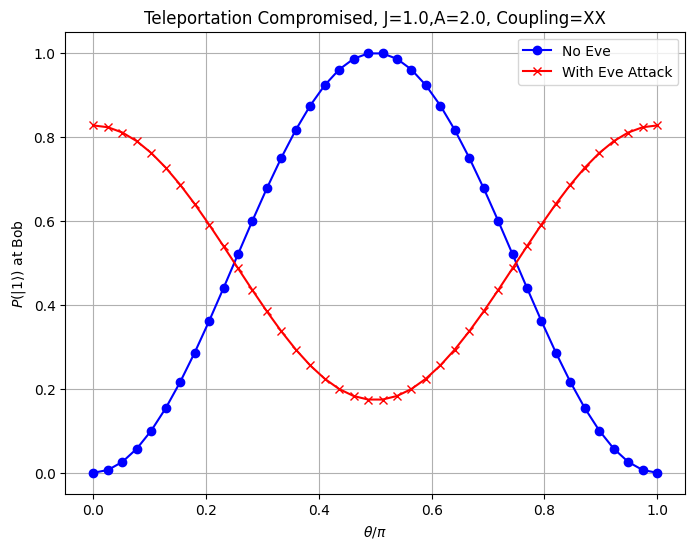

In [9]:
plot_teleportation_attack(
    J=1.0,
    A=2.0,
    delta = 0.0,
    coup=(qt.sigmax(), qt.sigmax()),
)

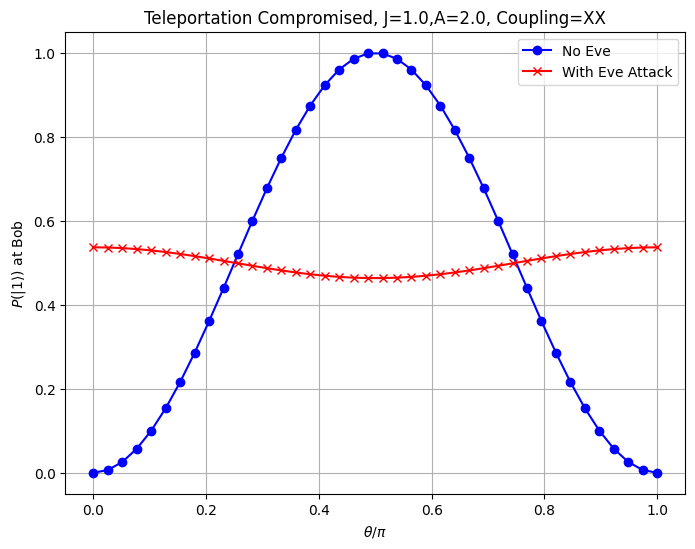

In [10]:
plot_teleportation_attack(
    J=1.0,
    A=2.0,
    delta = 2.1,
    coup=(qt.sigmax(), qt.sigmax()),
)

#delta = detuning

#Multi-mode attack

In [11]:
def apply_eve_multi_attack(state_pre, J, A, coup, delta=(0.0,0.0), eve_attack=False):
    sx = qt.sigmax()
    I  = qt.qeye(2)
    s1, s2 = coup
    A0, A1 = A
    delta0, delta1 = delta

    # Crosstalk Hamiltonian (couples q1-q2)
    H_couple = J * qt.tensor(I, s1, s2)

    # Time-dependent pulse functions
    def coeff0(t, args):
      return A0 * np.cos(delta0 * t)
    def coeff1(t, args):
      return A1 * np.cos(delta1 * t)

    # Drives
    H_p0 = [qt.tensor(sx, I, I), coeff0]
    H_p1 = [qt.tensor(I, sx, I), coeff1]

    H = [H_couple, H_p0, H_p1]
    t_attack = np.linspace(0, 1.0, 50)
    sol = qt.mesolve(H, state_pre, t_attack, [], [])
    return sol.states[-1]


In [12]:
def run_teleportation_all_outcomes(theta, J, A, coup, delta, eve_attack=False):
    # Step 1: prepare initial state and apply teleportation gates
    state_init = initial_state(theta)
    qc_gates = teleportation_gates()
    U_gates = gate_sequence_product(qc_gates.propagators())
    state_pre_measure = U_gates * state_init

    # Step 2: apply Eve's pulse attack if enabled
    if eve_attack:
        state_pre_measure = apply_eve_multi_attack(state_pre_measure, J, A, coup, delta)

    # Step 3: sum over all 4 measurement outcomes with proper correction
    final_state_bob = 0
    total_prob = 0

    for m0 in [0, 1]:
        for m1 in [0, 1]:
            # Projection operator on Alice's qubits
            proj_alice = qt.tensor(
                qt.basis(2, m0) * qt.basis(2, m0).dag(),
                qt.basis(2, m1) * qt.basis(2, m1).dag(),
                qt.qeye(2)
            )
            post_unnorm = proj_alice * state_pre_measure
            prob = post_unnorm.norm()**2

            if prob < 1e-12:
                continue

            state_post = post_unnorm.unit()

            # Apply local correction based on (m0, m1)
            qc_corr = QubitCircuit(3)
            if m1 == 1:
                qc_corr.add_gate(Gate("X", targets=[2]))
            if m0 == 1:
                qc_corr.add_gate(Gate("Z", targets=[2]))

            if qc_corr.gates:
                U_corr = gate_sequence_product(qc_corr.propagators())
                state_post = U_corr * state_post

            # Add weighted contribution
            rho_bob = state_post.ptrace(2)  # Bob's state
            final_state_bob += prob * rho_bob
            total_prob += prob

    # Normalize final result
    if total_prob > 0:
        return (final_state_bob / total_prob).unit()  # ⬅️ final fix: normalize
    else:
        return None


In [13]:
def plot_teleportation_multi_attack(J, A, coup, delta, thetas=None, num_points=40):
    if thetas is None:
        thetas = np.linspace(0, np.pi, num_points)

    P1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    prob_clean = []
    prob_eve   = []

    for θ in thetas:
        # clean run
        ρ_clean = run_teleportation_all_outcomes(θ, J, A, coup, delta, eve_attack=False)
        prob_clean.append(qt.expect(P1, ρ_clean) if ρ_clean else np.nan)

        # attacked run
        ρ_eve = run_teleportation_all_outcomes(θ, J, A, coup, delta, eve_attack=True)
        prob_eve.append(qt.expect(P1, ρ_eve) if ρ_eve else np.nan)

    C=xD(coup[0])+xD(coup[1])
    plt.figure(figsize=(8,6))
    plt.plot(thetas/np.pi, prob_clean,'b-o', label='No Eve')
    plt.plot(thetas/np.pi, prob_eve,  'r-x', label='With Eve Attack')
    plt.xlabel(r'$\theta/\pi$')
    plt.ylabel(r'$P(|1\rangle)$ at Bob')
    plt.title(f"Teleportation Compromised, J={J},A={A}, Coupling={C}")
    plt.legend()
    plt.grid(True)
    plt.ylim(-0.05, 1.05)
    plt.show()

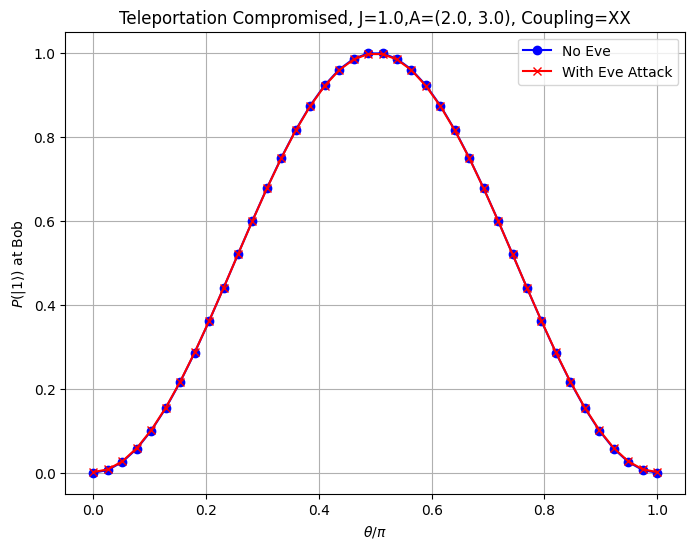

In [14]:
plot_teleportation_multi_attack(
    J=1.0,
    A=(2.0,3.0),
    delta = (2.1, 3.1),
    coup=(qt.sigmax(), qt.sigmax()),
)